In [3]:
import os
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

dataset_path = r"C:\Users\pasir\Desktop\PR_assignment\realwaste\realwaste-main\RealWaste"

classes = ["Cardboard", "Food Organics", "Glass", "Metal", "Miscellaneous Trash", "Paper", "Plastic", "Textile Trash", "Vegetation"]
class_paths = {cls: os.path.join(dataset_path, cls) for cls in classes}
class_paths

{'Cardboard': 'C:\\Users\\pasir\\Desktop\\PR_assignment\\realwaste\\realwaste-main\\RealWaste\\Cardboard',
 'Food Organics': 'C:\\Users\\pasir\\Desktop\\PR_assignment\\realwaste\\realwaste-main\\RealWaste\\Food Organics',
 'Glass': 'C:\\Users\\pasir\\Desktop\\PR_assignment\\realwaste\\realwaste-main\\RealWaste\\Glass',
 'Metal': 'C:\\Users\\pasir\\Desktop\\PR_assignment\\realwaste\\realwaste-main\\RealWaste\\Metal',
 'Miscellaneous Trash': 'C:\\Users\\pasir\\Desktop\\PR_assignment\\realwaste\\realwaste-main\\RealWaste\\Miscellaneous Trash',
 'Paper': 'C:\\Users\\pasir\\Desktop\\PR_assignment\\realwaste\\realwaste-main\\RealWaste\\Paper',
 'Plastic': 'C:\\Users\\pasir\\Desktop\\PR_assignment\\realwaste\\realwaste-main\\RealWaste\\Plastic',
 'Textile Trash': 'C:\\Users\\pasir\\Desktop\\PR_assignment\\realwaste\\realwaste-main\\RealWaste\\Textile Trash',
 'Vegetation': 'C:\\Users\\pasir\\Desktop\\PR_assignment\\realwaste\\realwaste-main\\RealWaste\\Vegetation'}

In [4]:
image_directory =r"C:\Users\pasir\Desktop\PR_assignment\realwaste\realwaste-main\RealWaste"

# Load the dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    image_directory,
    labels="inferred",       
    label_mode="int",       
    batch_size=32,           
    image_size=(224, 224),   
    shuffle=True             
)

class_names = train_dataset.class_names
print("Classes:", class_names)

for images, labels in train_dataset.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")

Found 4752 files belonging to 9 classes.
Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


In [5]:
# Load training and validation datasets
train_dataset = image_dataset_from_directory(
    image_directory,
    labels="inferred",       
    label_mode="int",         
    batch_size=32,           
    image_size=(224, 224),   
    shuffle=True,            
    validation_split=0.4,    
    subset="training",        
    seed=123                 
)

val_test_dataset = image_dataset_from_directory(
    image_directory,
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    validation_split=0.4,
    subset="validation",
    seed=123
)

# Split validation+testing into 20% validation and 20% testing
val_size = len(val_test_dataset) // 2
val_dataset = val_test_dataset.take(val_size)  
test_dataset = val_test_dataset.skip(val_size) 
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Check dataset sizes 
print(f"Training dataset size: {len(train_dataset)} batches")
print(f"Validation dataset size: {len(val_dataset)} batches")
print(f"Testing dataset size: {len(test_dataset)} batches")

Found 4752 files belonging to 9 classes.
Using 2852 files for training.
Found 4752 files belonging to 9 classes.
Using 1900 files for validation.
Training dataset size: 90 batches
Validation dataset size: 30 batches
Testing dataset size: 30 batches


In [6]:
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet

# Load ResNet50 pre-trained on ImageNet without the top (classification) layer
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained ResNet
for layer in resnet_model.layers:
    layer.trainable = False

# Add custom layers for fine-tuning ResNet
resnet_model_out = layers.GlobalAveragePooling2D()(resnet_model.output)
resnet_model_out = layers.Dense(128, activation='relu')(resnet_model_out)
resnet_model_out = layers.Dense(9, activation='softmax')(resnet_model_out)

# Create the ResNet-based model
resnet_model = models.Model(inputs=resnet_model.input, outputs=resnet_model_out)


# Load DenseNet121 pre-trained on ImageNet 
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers of DenseNet
for layer in densenet_model.layers:
    layer.trainable = False

densenet_model_out = layers.GlobalAveragePooling2D()(densenet_model.output)
densenet_model_out = layers.Dense(128, activation='relu')(densenet_model_out)
densenet_model_out = layers.Dense(9, activation='softmax')(densenet_model_out)

densenet_model = models.Model(inputs=densenet_model.input, outputs=densenet_model_out)


In [7]:
# Compile your model using sparse categorical crossentropy
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Now fit the model
history_resnet = resnet_model.fit(train_dataset, validation_data=val_dataset, epochs=10)


Epoch 1/10
90/90 [==============================] - 24s 105ms/step - loss: 2.1418 - accuracy: 0.1964 - val_loss: 2.0671 - val_accuracy: 0.2188
Epoch 2/10
90/90 [==============================] - 7s 77ms/step - loss: 2.0444 - accuracy: 0.2412 - val_loss: 2.0152 - val_accuracy: 0.3146
Epoch 3/10
90/90 [==============================] - 7s 77ms/step - loss: 2.0023 - accuracy: 0.2700 - val_loss: 1.9949 - val_accuracy: 0.2625
Epoch 4/10
90/90 [==============================] - 7s 77ms/step - loss: 1.9568 - accuracy: 0.2823 - val_loss: 1.9246 - val_accuracy: 0.3260
Epoch 5/10
90/90 [==============================] - 7s 76ms/step - loss: 1.9240 - accuracy: 0.3107 - val_loss: 1.8937 - val_accuracy: 0.3115
Epoch 6/10
90/90 [==============================] - 7s 78ms/step - loss: 1.8937 - accuracy: 0.3187 - val_loss: 1.8577 - val_accuracy: 0.3135
Epoch 7/10
90/90 [==============================] - 7s 78ms/step - loss: 1.8683 - accuracy: 0.3149 - val_loss: 1.8390 - val_accuracy: 0.3417
Epoch 8/10


In [8]:
# Compile the DenseNet-based model
densenet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_densenet = densenet_model.fit(train_dataset, validation_data=val_dataset, epochs=10)


Epoch 1/10
90/90 [==============================] - 18s 136ms/step - loss: 1.1448 - accuracy: 0.5926 - val_loss: 0.8420 - val_accuracy: 0.7021
Epoch 2/10
90/90 [==============================] - 11s 121ms/step - loss: 0.6341 - accuracy: 0.7802 - val_loss: 0.7712 - val_accuracy: 0.7167
Epoch 3/10
90/90 [==============================] - 11s 122ms/step - loss: 0.5301 - accuracy: 0.8117 - val_loss: 0.7902 - val_accuracy: 0.7188
Epoch 4/10
90/90 [==============================] - 11s 123ms/step - loss: 0.4090 - accuracy: 0.8594 - val_loss: 0.7261 - val_accuracy: 0.7521
Epoch 5/10
90/90 [==============================] - 11s 120ms/step - loss: 0.3386 - accuracy: 0.8906 - val_loss: 0.6988 - val_accuracy: 0.7427
Epoch 6/10
90/90 [==============================] - 11s 120ms/step - loss: 0.3147 - accuracy: 0.8948 - val_loss: 0.6242 - val_accuracy: 0.7823
Epoch 7/10
90/90 [==============================] - 11s 120ms/step - loss: 0.2404 - accuracy: 0.9288 - val_loss: 0.6664 - val_accuracy: 0.7781

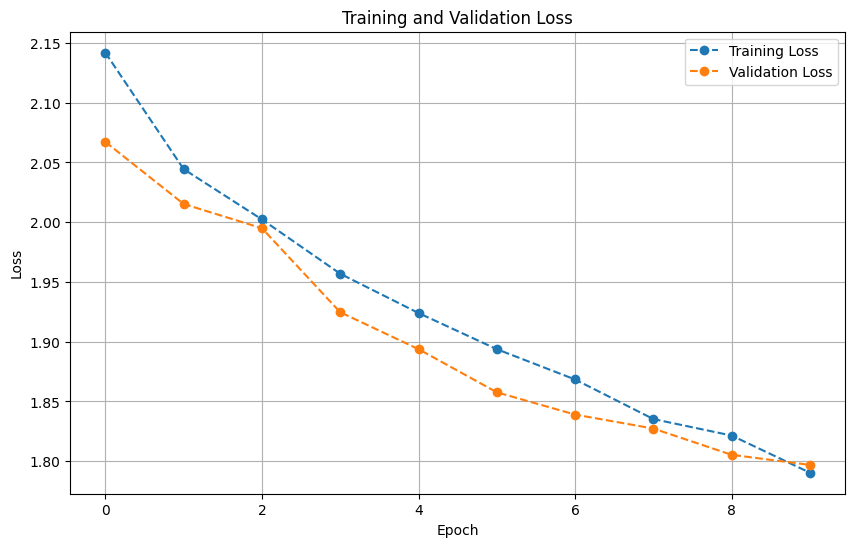

In [9]:
import matplotlib.pyplot as plt
# Plot training, validation, and testing loss with respect to epochs
plt.figure(figsize=(10, 6))
plt.plot(history_resnet.history['loss'], label='Training Loss', linestyle='--', marker='o')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss', linestyle='--', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

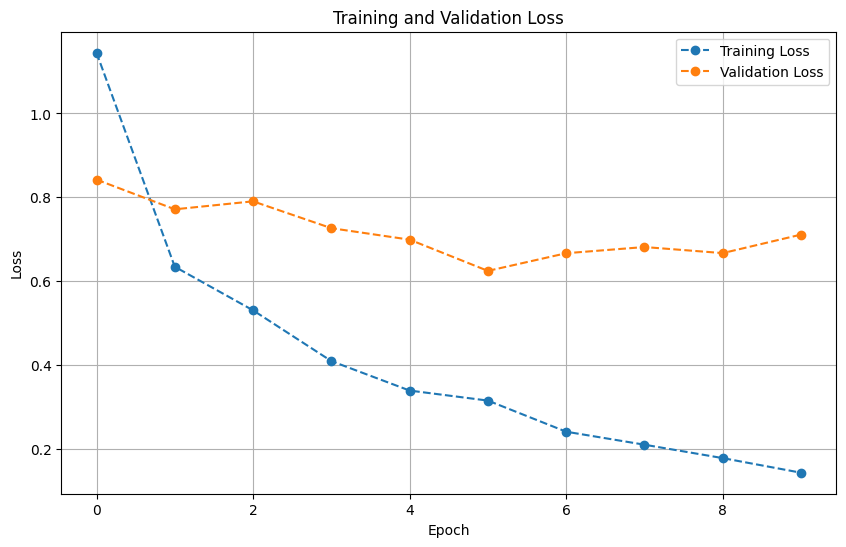

In [10]:
import matplotlib.pyplot as plt
# Plot training, validation, and testing loss with respect to epochs
plt.figure(figsize=(10, 6))
plt.plot(history_densenet.history['loss'], label='Training Loss', linestyle='--', marker='o')
plt.plot(history_densenet.history['val_loss'], label='Validation Loss', linestyle='--', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# Evaluate the model on the test data and collect test loss
test_loss, test_acc = resnet_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

30/30 [==============================] - 2s 57ms/step - loss: 1.8100 - accuracy: 0.3809
Test Loss: 1.8100234270095825
Test Accuracy: 0.38085106015205383


In [12]:
# Evaluate the model on the test data and collect test loss
test_loss, test_acc = densenet_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

30/30 [==============================] - 3s 87ms/step - loss: 0.6699 - accuracy: 0.8011
Test Loss: 0.6698740720748901
Test Accuracy: 0.8010638356208801
